In [1]:
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [2]:
# Simple Convolutional Autoencoder
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import math
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from model import *
from utils import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
GPU_NUM = int(torch.cuda.device_count())
print(GPU_NUM)

4


In [4]:
# Set Hyperparameters

task_num = 4
in_channels = 3
out_channels = 3
img_size = (64, 64)
epoch = 50
batch_size = 32
learning_rate = 0.0005

label = torch.eye(task_num, device=device)

In [5]:
train_dataset = make_dataset('/export/data/dataset/COCO/train2014/',img_size=img_size)
test_dataset = make_dataset('/export/data/dataset/COCO/val2014/',img_size=img_size)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=GPU_NUM)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=GPU_NUM)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 64, 64])


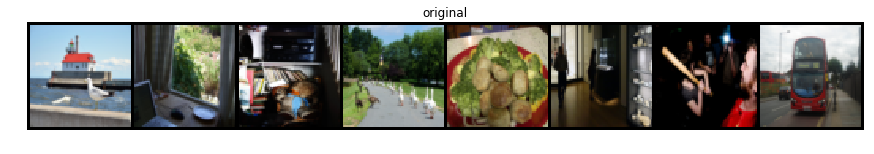

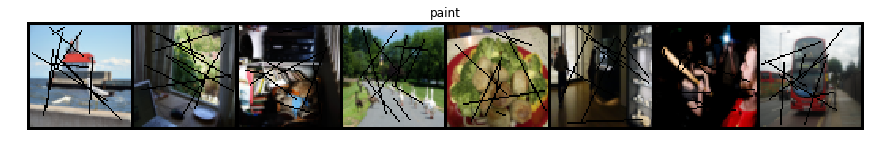

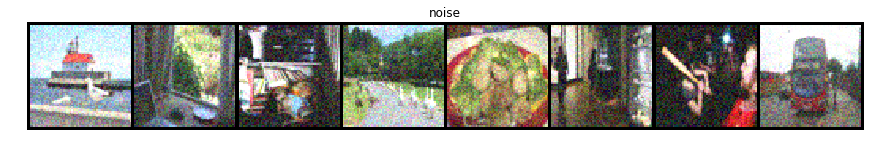

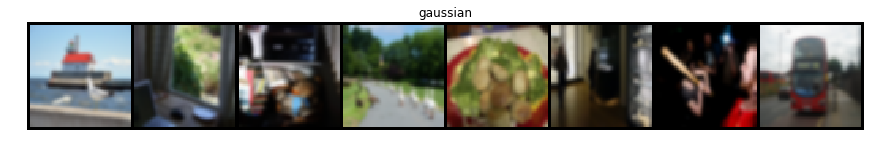

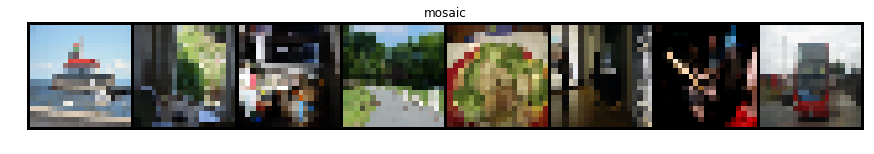

In [6]:
# 画像サンプル
samples = next(iter(test_loader))
show_img(samples[:8], 'original')
print(samples.shape)

samples_paint = paint(samples)
show_img(samples_paint[:8], 'paint')

samples_noise = noise(samples)
show_img(samples_noise[:8], 'noise')

samples_gaussian = gaussian(samples)
show_img(samples_gaussian[:8], 'gaussian')

samples_mosaic = mosaic(samples)
show_img(samples_mosaic[:8], 'mosaic')

## model

In [7]:
model = Model(in_channels=in_channels, out_channels=out_channels, dim_label=len(label)).to(device)
model = torch.nn.DataParallel(model)

## train

In [ ]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(model.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [ ]:
# train encoder and decoder
# save and load model
if not os.path.exists('model2'):
    os.mkdir('model2')
    print("directory maked")
    
load_epoch = 0
try:
    param = torch.load('./model2/model_{}.pth'.format(load_epoch))
    model.load_state_dict(param)
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(epoch):
    i = i + load_epoch
    for j,images in enumerate(train_loader):
        
        processed_images = torch.cat([paint(images[:8]), noise(images[8:16]), gaussian(images[16:24]), mosaic(images[24:32])], dim=0).to(device)
        label = label[0].unsqueeze(0).repeat(images.shape[0],1)
        
        images = images.to(device)
        
        optimizer.zero_grad()
        
        output = model(processed_images, label=label)
        
        loss = loss_func(output,images)
        loss.backward()
        
        optimizer.step()
        
        if j % 500 == 0:
            print('{}epoch:{}/{},loss:{}'.format(i+1,j,len(train_loader),loss.item()))
        
    if (i+1) % 2 == 0:
        torch.save(model.state_dict(),'./model2/model_{}.pth'.format(i+1))


--------model not restored--------

1epoch:0/2587,loss:0.4395890533924103
1epoch:500/2587,loss:0.014554043300449848
1epoch:1000/2587,loss:0.009226742200553417
1epoch:1500/2587,loss:0.008086821995675564
1epoch:2000/2587,loss:0.009768924675881863
1epoch:2500/2587,loss:0.011590954847633839
2epoch:0/2587,loss:0.007613837718963623
2epoch:500/2587,loss:0.0074364058673381805
2epoch:1000/2587,loss:0.007818215526640415
2epoch:1500/2587,loss:0.00726670166477561
2epoch:2000/2587,loss:0.0091859744861722
2epoch:2500/2587,loss:0.007413602899760008
3epoch:0/2587,loss:0.006831212434917688
3epoch:500/2587,loss:0.010666240938007832
3epoch:1000/2587,loss:0.006171628832817078
3epoch:1500/2587,loss:0.006644702982157469
3epoch:2000/2587,loss:0.0088158855214715
3epoch:2500/2587,loss:0.006848262622952461
4epoch:0/2587,loss:0.006346553564071655
4epoch:500/2587,loss:0.007573763374239206
4epoch:1000/2587,loss:0.005897489842027426
4epoch:1500/2587,loss:0.0052763610146939754
4epoch:2000/2587,loss:0.00633378326892